<a href="https://colab.research.google.com/github/shivkumarganesh/Deep-Learning-Course/blob/main/Assignment-1/DL_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all the possile Packages for ML

In [1]:
import pandas as pd
import matplotlib
import imgaug as ia
from keras.datasets import mnist
from matplotlib import pyplot
import sys
import imageio
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Activation, Dropout, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf

# Utility functions

In [2]:
# Plot the various Numbers
def printData(X_train):
  for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()


# Data augmentation using https://medium.com/@schatty/image-augmentation-in-numpy-the-spell-is-simple-but-quite-unbreakable-e1af57bb50fd
def data_augmentation(dataset, dataset_labels, augementation_factor=1, use_noise=True, use_random_shear=True, use_random_shift=True, use_scaling=True):
	augmented_image = []
	augmented_image_labels = []

	for num in range (0, dataset.shape[0]):
		for i in range(0, augementation_factor):
			transform_image=dataset[num]
			if use_noise:
				transform_image=iaa.AdditiveGaussianNoise(10,20).augment_image(transform_image)
			if use_random_shear:
				transform_image=iaa.Affine(shear=(0,40)).augment_image(transform_image)
			if use_scaling:
				transform_image=iaa.Affine(scale={"x": (1.5, 1.0), "y": (1.5, 1.0)}).augment_image(transform_image)
			augmented_image_labels.append(dataset_labels[num])
			augmented_image.append(transform_image)
	return np.array(augmented_image), np.array(augmented_image_labels)
 
 # Creation of Dropout mask
def create_drpot_mask(num,percentage):
  dCount=round((num/100)*percentage)
  dIndex=np.random.permutation(num)[:dCount]
  dMask=np.ones(num)
  for index in dIndex:
    dMask[index]=0
  return dMask

# Data Load and Visualization

In this section we load the data from the mnist dataset and then try to visualize the various labels of data that is available.

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


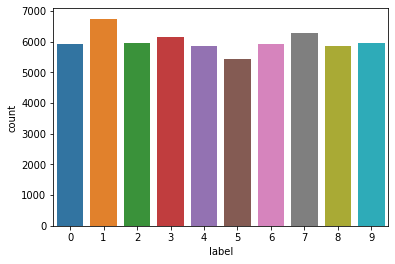

In [4]:
y_train_values = pd.DataFrame(y_train,columns=['label'])
y_col= y_train_values['label']
sns.countplot(y_col)

From the above we can see the various classigication of the data that is available in the mnist dataset.

# Lets Inspect the data available

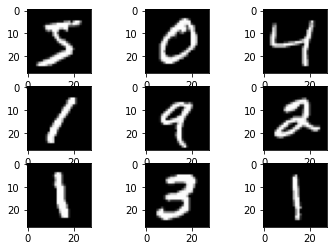

In [5]:
printData(X_train)

# Now lets perform Data Augmentation for the above Dataset
This part of the data Augmentation is just a sample data augmentation. Later in this assignment we will be using Keras for data Augmentation.

In [6]:
X_train_augmented,y_train_augmented=data_augmentation(X_train,y_train,1,True,True,True,True)

Post augmentation we will go ahead and print this data out so as to see how it looks. There are various transformations applied for example AdditiveGaussianNoise and Affine function

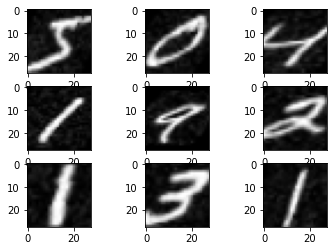

In [7]:
printData(X_train_augmented)

# Test Train Split the data
In this section we will be splitting the data into Test-Train sets. These sets will respectively be used in order to generate the dataset.

In [8]:
# X Train and Test
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

# Y Train and Test
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)
num_classes = Y_test.shape[1]

# Printing the values in order to understand the data
print('X_train.shape:')
print(X_train.shape)
print('X_test.shape:')
print(X_test.shape)
print('Y_train.shape:')
print(Y_train.shape)
print('Y_test.shape:')
print(Y_test.shape)


X_train.shape:
(60000, 784)
X_test.shape:
(10000, 784)
Y_train.shape:
(60000, 10)
Y_test.shape:
(10000, 10)


# Part 1  - Defining the Neural Net using Numpy

## Defining various layers Layers

In [9]:
class Layer:
  def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
    self.num_input_nodes = num_input_nodes
    self.num_output_nodes = num_output_nodes
    self.weights = 0.2 * np.random.random((num_input_nodes, num_output_nodes)) - 0.1
    self.bias = 0.2 * np.random.rand((1)) - 0.1
    self.X = np.zeros([num_input_nodes])

    if activation == 'relu':
      self.activation = Relu()
    else: 
      self.activation = None
  
  def forward(self, X, dropout):
    self.X = X.copy()

    self.Z = X @ self.weights + self.bias
    if self.activation == None:
      return self.Z 
    else:
      weights_dropout = np.random.binomial(1, dropout, size=self.Z.shape) / dropout
      return self.activation.forward(self.Z) * weights_dropout

  def predict(self, X):
    if self.activation == None:
      return X @ self.weights + self.bias 
    else:
      return self.activation.predict(X @ self.weights + self.bias)

  def backward(self, upstream_gradient):
    curr_upstream_gradient = upstream_gradient.copy()
    if self.activation != None:
      curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)

    self.dJdW = self.X.T @ curr_upstream_gradient
    self.dJdb = curr_upstream_gradient.sum()
    self.dJdX = curr_upstream_gradient @ self.weights.T
    return self.dJdX

  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}'.format(self.num_input_nodes, self.num_output_nodes, self.activation)

## RELU Activitation Function Definition

In [10]:
class Relu:
  def __init__(self):
    self.input = np.array([])

  def forward(self, input):
    self.input = input.copy()
    self.output = np.clip(self.input, 0, None)
    return self.output
  
  def predict(self, input):
    return np.clip(input, 0, None)
  
  def backward(self, upstream_gradient):
    return (self.input > 0) * upstream_gradient

  def update(self, lr):
    return

  def __str__(self):
    return 'ReLu'

## Defining the Neural Net Model

In [11]:
class NeuralModel:
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation))

    for i, layer in enumerate(self.layers):
      print('=== Layer {} ==='.format(i))
      print(layer)
    print()

  def forward(self, inputs, dropout):
    curr_out = inputs.copy()
    for l in self.layers:
      curr_out = l.forward(curr_out, dropout)
    return curr_out
  

  def predict(self, inputs):
    curr_out = inputs.copy()
    for l in self.layers:
      curr_out = l.predict(curr_out)
    return curr_out
  
  def backward(self, y_pred, y_true):
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    loss_gradient = mse.backward()

    gradient = loss_gradient.copy()
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)

  def fit(self, datagen, X_train_augmented, X_train, y_train, X_test, y_test, epochs, batch_size, dropout):
    train_errors = []
    train_accuracies = [] 
    test_errors = [] 
    test_accuracies = []
    for e in range(epochs):
      batches = 0
      for X_batch, y in datagen.flow(X_train_augmented, y_train, batch_size=batch_size):
        X = X_batch.reshape(X_batch.shape[0], 28*28) / 255.
        y_pred = self.forward(X, dropout)
        self.backward(y_pred, y)
        self.update(lr)

        if batches >= len(X_train_augmented) / batch_size:
          break
        batches += 1

      y_pred = self.predict(X_train)
      train_error = mean_squared_error(y_train, y_pred)
      train_errors.append(train_error)
      train_accuracy = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
      train_accuracies.append(train_accuracy)

      y_pred = self.predict(X_test)
      test_error = mean_squared_error(y_test, y_pred)
      test_errors.append(test_error)
      test_accuracy = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
      test_accuracies.append(test_accuracy)
      print('Epoch: {} Training Error: {} Training Accuracy: {} Validation Error: {} Validation Accuracy: {} '.format(e, round(train_error, 3), round(train_accuracy, 3), round(test_error, 3), round(test_accuracy, 3)))

    return train_errors, train_accuracies, test_errors, test_accuracies

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)


## Defining the mean squared error

In [12]:
# MEAN SQUARED ERROR
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient


## Hyper Parameters that we will be using for this particular exercise

In [13]:
lr = 0.01
batch_size = 128
epochs = 20
dropout = 0.25
hidden_layers = [128, 64]

n_inputs = X_train.shape[1]
n_outputs = Y_train.shape[1]
print(n_inputs, n_outputs)

784 10


## Data Augmentation

In [14]:
generated_data = ImageDataGenerator(
  rotation_range=10
)

X_train_augmented = X_train.reshape(-1,28,28,1)

In [15]:
# Create NeuralNet from implemented interface and train on MNIST dataset
nn = NeuralModel(num_inputs=n_inputs, num_hidden=hidden_layers, num_outputs=n_outputs, activation='relu')
train_errors, train_accuracies, test_errors, test_accuracies = nn.fit(generated_data, X_train_augmented, X_train, Y_train, X_test, Y_test, epochs, batch_size, dropout)

=== Layer 0 ===
Layer: (784,128) Activation Function: ReLu
=== Layer 1 ===
Layer: (128,64) Activation Function: ReLu
=== Layer 2 ===
Layer: (64,10) Activation Function: None

Epoch: 0 Training Error: 21.727 Training Accuracy: 0.558 Validation Error: 22.337 Validation Accuracy: 0.554 
Epoch: 1 Training Error: 23.838 Training Accuracy: 0.566 Validation Error: 24.647 Validation Accuracy: 0.567 
Epoch: 2 Training Error: 34.278 Training Accuracy: 0.38 Validation Error: 35.623 Validation Accuracy: 0.375 
Epoch: 3 Training Error: 35.178 Training Accuracy: 0.489 Validation Error: 36.429 Validation Accuracy: 0.489 
Epoch: 4 Training Error: 47.955 Training Accuracy: 0.414 Validation Error: 49.847 Validation Accuracy: 0.412 
Epoch: 5 Training Error: 56.408 Training Accuracy: 0.425 Validation Error: 58.286 Validation Accuracy: 0.431 
Epoch: 6 Training Error: 79.132 Training Accuracy: 0.449 Validation Error: 82.017 Validation Accuracy: 0.449 
Epoch: 7 Training Error: 93.114 Training Accuracy: 0.434

# Part 2 - Defining the Neural Net using Keras

## Now we will do the same thing using Keras

### Hyperparameter Definition

In [16]:
epochs = 100
batch_size = 128
learning_rate = 0.01

input_dimensions = X_train.shape[1]
no_of_classes = Y_train.shape[1]
print(input_dimensions)
print(no_of_classes)

784
10


## Data Augmentation

We will be augmenting the data using ImageDataGenerator which will help us to rotate our image. We can also do orizontal and vertical flip.

In [17]:
augmented_x_train = X_train.reshape(-1, 28, 28, 1)
augmented_x_test = X_test.reshape(-1, 28, 28, 1)

# Create image data generator to load images in batches
data_gen = ImageDataGenerator()
data_gen.fit(augmented_x_train)
train_batches = data_gen.flow(augmented_x_train, Y_train, batch_size=batch_size)
val_batches = data_gen.flow(augmented_x_test, Y_test, batch_size=batch_size)

# Training Sequencial Models

This is a simple Traning model using sequencial model using Keras.

In [18]:
model = Sequential()
model.add(Reshape((-1,), input_shape = (28, 28, 1)))
model.add(Dense(28 * 28, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))

model.add(Dense(10, activation='softmax'))

model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

history = model.fit(
  train_batches, 
  steps_per_epoch=augmented_x_train.shape[0] // batch_size,
  epochs=epochs, 
  validation_data=val_batches, 
  validation_steps=augmented_x_test.shape[0] // batch_size
)

Epoch 1/100
468/468 [==============================] - 10s 21ms/step - loss: nan - accuracy: 0.0993 - val_loss: nan - val_accuracy: 0.0980
Epoch 2/100
468/468 [==============================] - 9s 19ms/step - loss: nan - accuracy: 0.0972 - val_loss: nan - val_accuracy: 0.0979
Epoch 3/100
468/468 [==============================] - 9s 19ms/step - loss: nan - accuracy: 0.0971 - val_loss: nan - val_accuracy: 0.0982
Epoch 4/100
468/468 [==============================] - 9s 19ms/step - loss: nan - accuracy: 0.0976 - val_loss: nan - val_accuracy: 0.0980
Epoch 5/100
468/468 [==============================] - 9s 19ms/step - loss: nan - accuracy: 0.0968 - val_loss: nan - val_accuracy: 0.0980
Epoch 6/100
468/468 [==============================] - 9s 19ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0980
Epoch 7/100
468/468 [==============================] - 9s 19ms/step - loss: nan - accuracy: 0.0980 - val_loss: nan - val_accuracy: 0.0981
Epoch 8/100
468/468 [============